In [380]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
import copy
import requests
from concurrent.futures import ThreadPoolExecutor

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from pypfopt.expected_returns import ema_historical_return, capm_return
from pypfopt.risk_models import exp_cov, fix_nonpositive_semidefinite, CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt import objective_functions
from pypfopt import base_optimizer
import optuna

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import utils as ut

## Global Settings

In [256]:
seed = 1227
rs = np.random.RandomState(seed)

mpl.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

warnings.filterwarnings('ignore')

## Data

In [257]:
in_sample_data = pd.read_parquet('../data/in_sample_data.parquet')
out_sample_data = pd.read_parquet('../data/out_sample_data.parquet')
nasdaq = pd.read_csv('../data/nasdaq_100.csv', index_col=0)

in_sample_data.shape, out_sample_data.shape, nasdaq.shape

((1259, 30), (332, 30), (1591, 1))

We create a dictionary of ticker-sector key value pairs for use later when we add sector constraints:

In [258]:
# Sector mappings
nasdaq_obj = ut.Nasdaq100(in_sample_data.columns.tolist())
sector_mappings = {ticker: sector for ticker, sector in zip(nasdaq_obj.tickers, nasdaq_obj.get_industries())}
sector_mappings

{'AAPL': 'Technology',
 'AMZN': 'Retail',
 'BIIB': 'Healthcare',
 'CMCSA': 'Telecom',
 'CME': 'Financial Services',
 'COST': 'Retail',
 'CSCO': 'Technology',
 'EA': 'Technology',
 'EBAY': 'Retail',
 'GOOG': 'Technology',
 'HD': 'Retail',
 'HON': 'Manufacturing',
 'INTC': 'Technology',
 'JPM': 'Financial Services',
 'LULU': 'Retail',
 'META': 'Technology',
 'MSFT': 'Technology',
 'NFLX': 'Media & Entertainment',
 'NVDA': 'Technology',
 'ORLY': 'Consumer Discretionary',
 'PEP': 'Consumer Staples',
 'PFE': 'Healthcare',
 'PYPL': 'Technology',
 'QCOM': 'Technology',
 'SBUX': 'Consumer Discretionary',
 'TSLA': 'Consumer Discretionary',
 'TXN': 'Technology',
 'VRTX': 'Healthcare',
 'WDAY': 'Technology',
 'XEL': 'Utilities'}

## Objective Function 

The objective function will allow us to select different combinations of strategies and select the one that performs the best based on a performance metric on the out sample data (past 16 months). The metric we will optimize (maximize) is the sharpe ratio of the portfolio given the following inputs:

* Optimal weights of the optimization model

* Out sample expected returns

* Out sample covariance matrix estimator

* Risk free rate, which is interpolated from the yield curve as follows:

In [259]:
# Child 4 indicates the row of the table corresponding to the most recent day, e.g., 2023-03-06 
# See https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve
selectors = [
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.bc1month.views-field.views-field-field-bc-1month',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.bc3month.views-field.views-field-field-bc-3month',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-6month',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-1year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-2year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.bc3month.views-field.views-field-field-bc-3year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-5year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-7year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-10year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.bc20year.views-field.views-field-field-bc-20year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.bc30year.views-field.views-field-field-bc-30year'
]

# Function to scrape the yield curve from the treasury.gov website
def get_yield_curve(selector: str) -> float:
    """
    Parameters
    ----------
    selector : str
        A CSS selector string for the yield curve data for a given maturity and date.

    Returns
    -------
    float
        A yield curve value for a given maturity.
    """
    url = 'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2016'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    element = soup.select_one(selector)
    
    return float(element.text.strip()) # Remove leading and trailing whitespace and convert rate to float

with ThreadPoolExecutor() as executor: # Use all available cores
    results = list(executor.map(get_yield_curve, selectors))

Now, we interpolate the 16 month constant maturity rate using cubic interpolation:

In [260]:
# Rates and maturities are in the same order
rates = np.array(results)
maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])

# Create an interpolation function using cubic interpolation
f = interp1d(maturities, rates, kind='cubic')

# Interpolate the 16-month rate
rate_16m = float(f(16/12))

print("Interpolated 16-month rate:", rate_16m)

Interpolated 16-month rate: 0.6820014420816192


We can plot the yield curve using cubic spline:

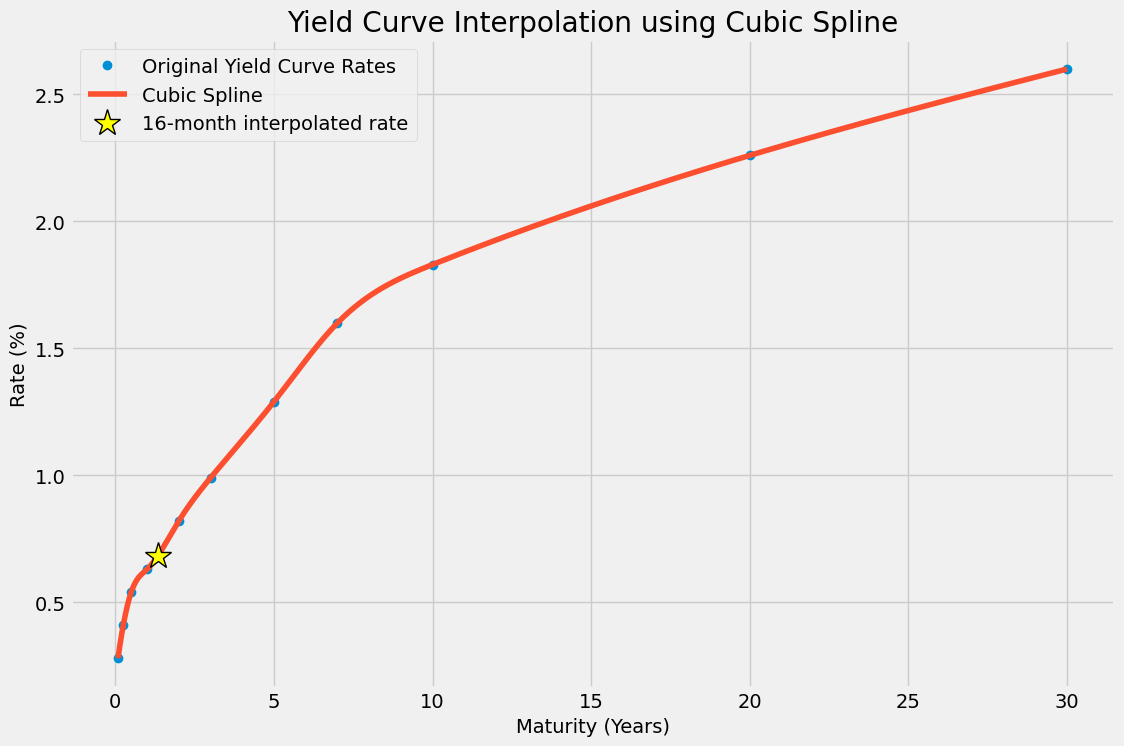

In [261]:
plt.plot(maturities, rates, 'o', label='Original Yield Curve Rates') # Using 'o' (circle marker) to denote the original data points

# Plot the interpolated yield curve using cubic spline
maturities_cubic_spline = np.linspace(maturities.min(), maturities.max(), 1000)
rates_cubic_spline = f(maturities_cubic_spline)
plt.plot(maturities_cubic_spline , rates_cubic_spline, '-', label='Cubic Spline') # Using '-' (solid line) to denote the interpolated data points

# Plot the 16-month interpolated rate
plt.plot(16/12, rate_16m, '*', label='16-month interpolated rate', markersize=20, markerfacecolor='yellow', markeredgecolor='black')

plt.title('Yield Curve Interpolation using Cubic Spline')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rate (%)')
plt.legend()

# display the plot
plt.show();

We now split the training sample into training and validation sets:

In [262]:
split_date = in_sample_data.index.max() - pd.DateOffset(months=16)

in_sample_data_train = in_sample_data.loc[:split_date]
in_sample_data_val = in_sample_data.loc[split_date:]

(in_sample_data_train.index.min(), in_sample_data_train.index.max())
(in_sample_data_val.index.min(), in_sample_data_val.index.max())

(Timestamp('2016-11-07 00:00:00'), Timestamp('2020-07-02 00:00:00'))

(Timestamp('2020-07-06 00:00:00'), Timestamp('2021-11-05 00:00:00'))

In [309]:
def objective(trial):
    
    # -------------------------- Initial hyperparameters ------------------------- #
    
    params = {
        'expected_return_model': trial.suggest_categorical('expected_return_model', ['capm', 'exp_weighted']),
        'risk_model': trial.suggest_categorical('risk_model', ['exp_weighted', 'shrinkage']),
        'reg_gamma': trial.suggest_int('reg_gamma', 1, 3)
    }
    
    # ------------------------------- Returns model ------------------------------ #
    
    # If the expected return model is capm, then we need to specify the risk free rate
    if params['expected_return_model'] == 'capm':
        
        returns_train = capm_return(
            prices=in_sample_data_train,
            returns_data=False,
            risk_free_rate=rate_16m
        )
        
        returns_val = capm_return(
            prices=in_sample_data_val,
            returns_data=False,
            risk_free_rate=rate_16m
        )
    else:
        # If the expected return model is exp_weighted, then we need to specify the 'span' parameter for the exponential moving average
        params['returns_span'] = trial.suggest_int('returns_span', 200, 700)
        
        returns_train = ema_historical_return(
            prices=in_sample_data_train,
            span=params['returns_span'],
            returns_data=False,
            frequency=252,
            compounding=True
        )
        
        returns_val = ema_historical_return(
            prices=in_sample_data_val,
            span=params['returns_span'],
            returns_data=False,
            frequency=252,
            compounding=True
        )

    # -------------------------------- Risk model -------------------------------- #
    
    # If the risk model is shrinkage, then we need to specify the shrinkage target
    if params['risk_model'] == 'shrinkage':
        
        params['shrinkage_target'] = trial.suggest_categorical('shrinkage_target', ['constant_variance', 'single_factor', 'constant_correlation'])
        
        shrinkage_model_train = CovarianceShrinkage(prices=in_sample_data_train, returns_data=False, frequency=252)
        shrinkage_model_val = CovarianceShrinkage(prices=in_sample_data_val, returns_data=False, frequency=252)
        
        cov_train = shrinkage_model_train.ledoit_wolf(params['shrinkage_target'])
        cov_val = shrinkage_model_val.ledoit_wolf(params['shrinkage_target'])
        
        # Check for positive semi-definiteness
        cov_train = fix_nonpositive_semidefinite(cov_train)
        cov_val = fix_nonpositive_semidefinite(cov_val)
        
    else: 
        # If the risk model is exp_weighted, then we need to specify the 'span' parameter for the exponential moving average
        # This allows us to use different spans for the returns and covariance matrices
        params['cov_span'] = trial.suggest_int('cov_span', 200, 700)
        
        cov_train = exp_cov(
            prices=in_sample_data_train,
            returns_data=False,
            span=params['cov_span'],
            frequency=252
        )
        
        cov_val = exp_cov(
            prices=in_sample_data_val,
            returns_data=False,
            span=params['cov_span'],
            frequency=252
        )
        
        # Check for positive semi-definiteness
        cov_train = fix_nonpositive_semidefinite(cov_train)
        cov_val = fix_nonpositive_semidefinite(cov_val)
        
    # ------------------------------- Optimization ------------------------------- #
    
    # Create the optimization model
    markowitz_model = EfficientFrontier(
        expected_returns=returns_train.to_numpy().flatten(),
        cov_matrix=cov_train,
        weight_bounds=(0, 1), # Assume fully invested portfolio
        solver=None # Use cvxpy’s default choice of solver
    )
    
    # Add sector constraints (the sector_mappings dictionary is scoped from the enclosing environment)
    markowitz_model.add_sector_constraints(
        sector_mapper=sector_mappings, 
        sector_lower={'Technology': 0.1}, # At least 10% of the portfolio should be invested in the Technology sector
        sector_upper={'Technology': 0.3} # At most 30% of the portfolio should be invested in the Technology sector
    )
    
    # Add the regularization term (tuning gamma i.e., the higher the value of gamma, the more non-negligible weights)
    markowitz_model.add_objective(objective_functions.L2_reg, gamma=params['reg_gamma'])
    
    try:
        optimal_weights = markowitz_model.max_sharpe(risk_free_rate=rate_16m)
    except:
        print('Optimization failed')
        return np.inf
    
    # -------------------------------- Evaluation -------------------------------- #
    
    # Out of sample performance
    negated_val_sample_sharpe = objective_functions.sharpe_ratio(
        w=np.array(list(optimal_weights.values())), 
        expected_returns=returns_val.to_numpy().flatten(), 
        cov_matrix=cov_val,
        risk_free_rate=rate_16m,
        negative=True # Calculate the negative sharpe ratio, so we can minimize the optuna objective function
    )
    
    print('Validation sharpe ratio: {}'.format(negated_val_sample_sharpe))
    
    return negated_val_sample_sharpe

In [290]:
# Create the study object
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(), 
    study_name='min_neg_sharpe', 
    direction='minimize', 
    pruner=optuna.pruners.HyperbandPruner() # Prune unpromising trials
)
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2023-03-08 04:17:22,673] A new study created in memory with name: min_neg_sharpe
[I 2023-03-08 04:17:22,856] Trial 5 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'constant_variance'}. Best is trial 5 with value: inf.
[I 2023-03-08 04:17:22,859] Trial 1 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'shrinkage_target': 'constant_correlation'}. Best is trial 5 with value: inf.
[I 2023-03-08 04:17:22,898] Trial 4 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'shrinkage_target': 'constant_variance'}. Best is trial 5 with value: inf.
[I 2023-03-08 04:17:22,930] Trial 6 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'constant_correlation'}. Best is trial 5 with value:

Optimization failedOptimization failed

Optimization failed
Optimization failed


[I 2023-03-08 04:17:23,178] Trial 8 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'shrinkage_target': 'constant_correlation'}. Best is trial 5 with value: inf.
[I 2023-03-08 04:17:23,282] Trial 11 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'single_factor'}. Best is trial 5 with value: inf.


Optimization failed
Optimization failed


[I 2023-03-08 04:17:23,506] Trial 0 finished with value: -3.540258823286463 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 368, 'shrinkage_target': 'constant_variance'}. Best is trial 0 with value: -3.540258823286463.
[I 2023-03-08 04:17:23,621] Trial 9 finished with value: -3.2101286839580303 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 494, 'shrinkage_target': 'constant_correlation'}. Best is trial 0 with value: -3.540258823286463.


Validation sharpe ratio: -3.540258823286463
Validation sharpe ratio: -3.2101286839580303


[I 2023-03-08 04:17:23,769] Trial 3 finished with value: -3.676238056484164 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 305, 'shrinkage_target': 'constant_correlation'}. Best is trial 3 with value: -3.676238056484164.
[I 2023-03-08 04:17:23,881] Trial 10 finished with value: -3.075711109154586 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 692, 'shrinkage_target': 'single_factor'}. Best is trial 3 with value: -3.676238056484164.


Validation sharpe ratio: -3.676238056484164
Validation sharpe ratio: -3.075711109154586


[I 2023-03-08 04:17:24,313] Trial 16 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'shrinkage_target': 'constant_correlation'}. Best is trial 3 with value: -3.676238056484164.
[I 2023-03-08 04:17:24,492] Trial 12 finished with value: -4.423904728454512 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 230, 'shrinkage_target': 'constant_variance'}. Best is trial 12 with value: -4.423904728454512.


Optimization failed
Validation sharpe ratio: -4.423904728454512


[I 2023-03-08 04:17:25,592] Trial 2 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 2, 'cov_span': 494}. Best is trial 12 with value: -4.423904728454512.


Optimization failed


[I 2023-03-08 04:17:26,199] Trial 7 finished with value: -4.236145394488122 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 2, 'returns_span': 300, 'cov_span': 398}. Best is trial 12 with value: -4.423904728454512.


Validation sharpe ratio: -4.236145394488122


[I 2023-03-08 04:17:26,938] Trial 13 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 2, 'cov_span': 554}. Best is trial 12 with value: -4.423904728454512.


Optimization failed


[I 2023-03-08 04:17:28,623] Trial 14 finished with value: -4.241801381531044 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 2, 'returns_span': 332, 'cov_span': 314}. Best is trial 12 with value: -4.423904728454512.


Validation sharpe ratio: -4.241801381531044


[I 2023-03-08 04:17:29,935] Trial 15 finished with value: -3.882701280727991 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 1, 'returns_span': 548, 'cov_span': 294}. Best is trial 12 with value: -4.423904728454512.
[I 2023-03-08 04:17:30,063] Trial 18 finished with value: -4.512782446649576 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 1, 'returns_span': 249, 'cov_span': 636}. Best is trial 18 with value: -4.512782446649576.


Validation sharpe ratio: -3.882701280727991
Validation sharpe ratio: -4.512782446649576


[I 2023-03-08 04:17:30,361] Trial 17 finished with value: -4.400894264842051 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 259, 'cov_span': 457}. Best is trial 18 with value: -4.512782446649576.


Validation sharpe ratio: -4.400894264842051


[I 2023-03-08 04:17:30,611] Trial 19 finished with value: -5.036246951041608 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 209, 'cov_span': 535}. Best is trial 19 with value: -5.036246951041608.


Validation sharpe ratio: -5.036246951041608


[I 2023-03-08 04:17:31,749] Trial 20 finished with value: -6.013670290425231 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 202, 'cov_span': 217}. Best is trial 20 with value: -6.013670290425231.


Validation sharpe ratio: -6.013670290425231


[I 2023-03-08 04:17:31,969] Trial 21 finished with value: -5.705488394129832 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 212, 'cov_span': 229}. Best is trial 20 with value: -6.013670290425231.
[I 2023-03-08 04:17:32,133] Trial 22 finished with value: -5.778177352473223 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 212, 'cov_span': 215}. Best is trial 20 with value: -6.013670290425231.


Validation sharpe ratio: -5.705488394129832
Validation sharpe ratio: -5.778177352473223


[I 2023-03-08 04:17:32,815] Trial 23 finished with value: -5.384838943738965 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 234, 'cov_span': 209}. Best is trial 20 with value: -6.013670290425231.


Validation sharpe ratio: -5.384838943738965


[I 2023-03-08 04:17:34,674] Trial 25 finished with value: -4.977211708885045 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 206, 'cov_span': 674}. Best is trial 20 with value: -6.013670290425231.


Validation sharpe ratio: -4.977211708885045


[I 2023-03-08 04:17:35,002] Trial 24 finished with value: -4.989511875152396 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 205, 'cov_span': 687}. Best is trial 20 with value: -6.013670290425231.


Validation sharpe ratio: -4.989511875152396


[I 2023-03-08 04:17:35,425] Trial 26 finished with value: -5.16124453100212 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 1, 'returns_span': 205, 'cov_span': 675}. Best is trial 20 with value: -6.013670290425231.
[I 2023-03-08 04:17:35,626] Trial 27 finished with value: -5.095248640336799 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 200, 'cov_span': 695}. Best is trial 20 with value: -6.013670290425231.


Validation sharpe ratio: -5.16124453100212
Validation sharpe ratio: -5.095248640336799


[I 2023-03-08 04:17:36,934] Trial 28 finished with value: -6.0866689904745535 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 201, 'cov_span': 209}. Best is trial 28 with value: -6.0866689904745535.
[I 2023-03-08 04:17:37,063] Trial 30 finished with value: -6.048334342705279 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 204, 'cov_span': 202}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -6.0866689904745535
Validation sharpe ratio: -6.048334342705279


[I 2023-03-08 04:17:37,260] Trial 29 finished with value: -6.0328697713287704 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 203, 'cov_span': 209}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -6.0328697713287704


[I 2023-03-08 04:17:37,914] Trial 31 finished with value: -4.282499625727314 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 393, 'cov_span': 208}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.282499625727314


[I 2023-03-08 04:17:39,772] Trial 32 finished with value: -4.196668390375766 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 393, 'cov_span': 231}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.196668390375766


[I 2023-03-08 04:17:41,417] Trial 34 finished with value: -4.274946570122634 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 407, 'cov_span': 200}. Best is trial 28 with value: -6.0866689904745535.
[I 2023-03-08 04:17:41,610] Trial 35 finished with value: -4.348326221727151 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 355, 'cov_span': 225}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.274946570122634
Validation sharpe ratio: -4.348326221727151


[I 2023-03-08 04:17:41,716] Trial 33 finished with value: -4.383844770927426 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 365, 'cov_span': 207}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.383844770927426


[I 2023-03-08 04:17:42,837] Trial 36 finished with value: -4.134953301859817 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 364, 'cov_span': 282}. Best is trial 28 with value: -6.0866689904745535.
[I 2023-03-08 04:17:42,929] Trial 37 finished with value: -4.023330052830532 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 398, 'cov_span': 285}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.134953301859817
Validation sharpe ratio: -4.023330052830532


[I 2023-03-08 04:17:43,134] Trial 38 finished with value: -4.108824544366661 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 379, 'cov_span': 274}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.108824544366661


[I 2023-03-08 04:17:43,713] Trial 39 finished with value: -4.557470494701696 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 279, 'cov_span': 285}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.557470494701696


[I 2023-03-08 04:17:44,040] Trial 40 finished with value: -4.49969881464256 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 282, 'cov_span': 297}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.49969881464256


[I 2023-03-08 04:17:45,363] Trial 41 finished with value: -4.6209444707094205 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 273, 'cov_span': 281}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.6209444707094205


[I 2023-03-08 04:17:46,040] Trial 42 finished with value: -4.508327213337082 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 278, 'cov_span': 306}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.508327213337082


[I 2023-03-08 04:17:46,428] Trial 43 finished with value: -4.529260074891959 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 279, 'cov_span': 295}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.529260074891959


[I 2023-03-08 04:17:47,564] Trial 47 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 2, 'cov_span': 358}. Best is trial 28 with value: -6.0866689904745535.
[I 2023-03-08 04:17:47,757] Trial 44 finished with value: -4.545168571584023 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 271, 'cov_span': 315}. Best is trial 28 with value: -6.0866689904745535.


Optimization failed
Validation sharpe ratio: -4.545168571584023


[I 2023-03-08 04:17:47,804] Trial 45 finished with value: -4.417722805916981 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 280, 'cov_span': 337}. Best is trial 28 with value: -6.0866689904745535.
[I 2023-03-08 04:17:47,835] Trial 46 finished with value: -4.535946269943271 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 2, 'returns_span': 271, 'cov_span': 349}. Best is trial 28 with value: -6.0866689904745535.
[I 2023-03-08 04:17:47,970] Trial 48 finished with value: -4.631902207361679 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 252, 'cov_span': 361}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.417722805916981
Validation sharpe ratio: -4.535946269943271
Validation sharpe ratio: -4.631902207361679


[I 2023-03-08 04:17:48,181] Trial 49 finished with value: -4.622620239993569 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 2, 'returns_span': 264, 'cov_span': 339}. Best is trial 28 with value: -6.0866689904745535.


Validation sharpe ratio: -4.622620239993569


In [291]:
# Plot the optimization history
optuna.visualization.plot_optimization_history(study)

## Tuned Portfolio Strategy

In [292]:
study.best_params

{'expected_return_model': 'exp_weighted',
 'risk_model': 'exp_weighted',
 'reg_gamma': 3,
 'returns_span': 201,
 'cov_span': 209}

As can be seen, the tuned portfolio strategy includes:

* Exponentially weighted returns with a span of 201 days

* Exponentially weighted covariance matrix with a span of 209 days

* L2 regularization with gamma equaling 3

In [315]:
# Returns and risk models
returns_models = {}
risk_models = {}
for sample, data in zip(['train', 'val', 'test'], [in_sample_data_train, in_sample_data_val, out_sample_data]):
    
    returns_models[sample] = ema_historical_return(
        prices=data,
        span=study.best_params['returns_span'],
        returns_data=False,
        frequency=252,
        compounding=True
    )
    
    risk_models[sample] = fix_nonpositive_semidefinite(
        exp_cov(
            prices=data,
            returns_data=False,
            span=study.best_params['cov_span'],
            frequency=252
        )
    )

In [316]:
# Create the optimization model
markowitz_model = EfficientFrontier(
    expected_returns=returns_models['train'].to_numpy().flatten(),
    cov_matrix=risk_models['train'],
    weight_bounds=(0, 1), # Assume fully invested portfolio
    solver=None # Use cvxpy’s default choice of solver
)

# Add sector constraints (the sector_mappings dictionary is scoped from the enclosing environment)
markowitz_model.add_sector_constraints(
    sector_mapper=sector_mappings, 
    sector_lower={'Technology': 0.1}, # At least 10% of the portfolio should be invested in the Technology sector
    sector_upper={'Technology': 0.3} # At most 30% of the portfolio should be invested in the Technology sector
)

# Add the regularization term (tuning gamma i.e., the higher the value of gamma, the more non-negligible weights)
markowitz_model.add_objective(objective_functions.L2_reg, gamma=study.best_params['reg_gamma'])

Plot the efficient frontier:

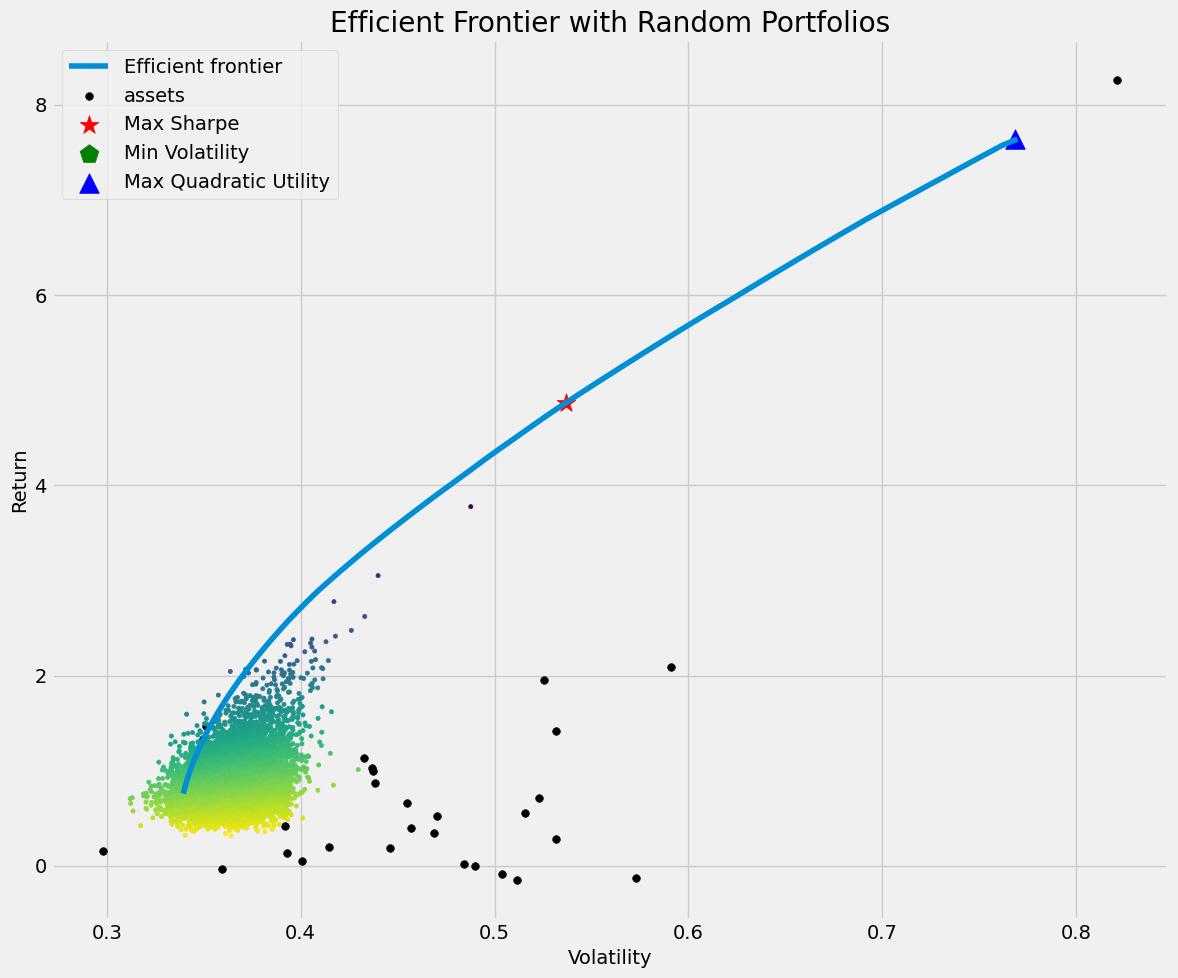

In [317]:
ut.custom_efficient_frontier(markowitz_model);

Optimize for sharpe ratio and obtain the optimal weights:

In [318]:
optimal_weights = markowitz_model.max_sharpe(risk_free_rate=rate_16m)
optimal_weights_array = np.array(list(optimal_weights.values()))
optimal_weights

OrderedDict([('AAPL', 0.0),
             ('AMZN', 0.0348729677383076),
             ('BIIB', 0.0),
             ('CMCSA', 0.0),
             ('CME', 0.0),
             ('COST', 0.0),
             ('CSCO', 0.0),
             ('EA', 0.0),
             ('EBAY', 0.0609208582493061),
             ('GOOG', 0.0),
             ('HD', 0.0),
             ('HON', 0.0),
             ('INTC', 0.0),
             ('JPM', 0.0),
             ('LULU', 0.0137639209135602),
             ('META', 0.0),
             ('MSFT', 0.0),
             ('NFLX', 0.0),
             ('NVDA', 0.0861977375500128),
             ('ORLY', 0.0),
             ('PEP', 0.0),
             ('PFE', 0.0),
             ('PYPL', 0.0842235418258415),
             ('QCOM', 0.0),
             ('SBUX', 0.0),
             ('TSLA', 0.7200209737229717),
             ('TXN', 0.0),
             ('VRTX', 0.0),
             ('WDAY', 0.0),
             ('XEL', 0.0)])

In [319]:
# In sample performance
train_performance = markowitz_model.portfolio_performance(risk_free_rate=rate_16m)
for metric, value in zip(['Return', 'Risk', 'Sharpe Ratio'], train_performance):
    print(f'{metric}: {round(value, 4)}')

Return: 6.4466
Risk: 0.6623
Sharpe Ratio: 8.7035


In [320]:
val_performance = base_optimizer.portfolio_performance(
    weights=optimal_weights,
    expected_returns=returns_models['val'].to_numpy().flatten(),
    cov_matrix=risk_models['val'],
    risk_free_rate=rate_16m
)
for metric, value in zip(['Return', 'Risk', 'Sharpe Ratio'], val_performance):
    print(f'{metric}: {round(value, 4)}')

Return: 3.0851
Risk: 0.3948
Sharpe Ratio: 6.0867


In [321]:
test_performance = base_optimizer.portfolio_performance(
    weights=optimal_weights,
    expected_returns=returns_models['test'].to_numpy().flatten(),
    cov_matrix=risk_models['test'],
    risk_free_rate=rate_16m
)
for metric, value in zip(['Return', 'Risk', 'Sharpe Ratio'], test_performance):
    print(f'{metric}: {round(value, 4)}')

Return: 0.1374
Risk: 0.5733
Sharpe Ratio: -0.9498


### Benchmark Performance

In [327]:
# Train, validation, and test sets
nasdaq_train = nasdaq.loc[:split_date.strftime('%Y-%m-%d')]
nasdaq_val = nasdaq.loc[split_date.strftime('%Y-%m-%d'):in_sample_data.index.max().strftime('%Y-%m-%d')]
nasdaq_test = nasdaq.loc[out_sample_data.index.min().strftime('%Y-%m-%d'):]

(nasdaq_train.index.min(), nasdaq_train.index.max())
(nasdaq_val.index.min(), nasdaq_val.index.max())
(nasdaq_test.index.min(), nasdaq_test.index.max())

('2016-11-08', '2020-07-02')

('2020-07-06', '2021-11-05')

('2021-11-08', '2023-03-07')

In [337]:
nasdaq_returns = {}
nasdaq_risk = {}
sharpe_ratios = {}

for sample, data in zip(['train', 'val', 'test'], [nasdaq_train, nasdaq_val, nasdaq_test]):
    nasdaq_returns[sample] = ema_historical_return(
        prices=data,
        span=study.best_params['returns_span'],
        returns_data=False,
        frequency=252,
        compounding=True
    )
    
    nasdaq_risk[sample] = fix_nonpositive_semidefinite(
        exp_cov(
            prices=data,
            returns_data=False,
            span=study.best_params['cov_span'],
            frequency=252
        )
    )['Adj Close']
    
    sharpe_ratios[sample] = (nasdaq_returns[sample] - rate_16m) / nasdaq_risk[sample]

In [338]:
for sample in ['train', 'val', 'test']:
    print(f'Nasdaq {sample} returns: {round(nasdaq_returns[sample].values[0], 4)}')

Nasdaq train returns: 0.66
Nasdaq val returns: 0.4568
Nasdaq test returns: 0.0342


In [339]:
for sample in ['train', 'val', 'test']:
    print(f'Nasdaq {sample} volatility: {round(nasdaq_risk[sample].values[0], 4)}')

Nasdaq train volatility: 0.1355
Nasdaq val volatility: 0.0273
Nasdaq test volatility: 0.0833


In [340]:
for sample in ['train', 'val', 'test']:
    print(f'Nasdaq {sample} sharpe ratio: {round(sharpe_ratios[sample].values[0], 4)}')

Nasdaq train sharpe ratio: -0.1626
Nasdaq val sharpe ratio: -8.2475
Nasdaq test sharpe ratio: -7.7765


## Post Processing

In [382]:
# Create a random vector of prices (we may change the stocks later and so we will look up the prices then)
lastest_prices = pd.Series(np.random.uniform(50, 200, size=30).round(4), index=returns_models['train'].index)
lastest_prices.head(5)

AAPL     110.5914
AMZN     133.7126
BIIB      76.4743
CMCSA     60.0465
CME      177.4429
dtype: float64

In [384]:
# Instantiate a instance of DiscreteAllocation
da = DiscreteAllocation(
    weights=optimal_weights,
    latest_prices=lastest_prices,
    total_portfolio_value=62556
)

In [385]:
# Solve integer programming problem
allocations = da.lp_portfolio(reinvest=False)
allocations

({'AMZN': 16, 'EBAY': 25, 'LULU': 12, 'NVDA': 85, 'PYPL': 38, 'TSLA': 630},
 65.89886812993063)

In [386]:
da._allocation_rmse_error()

AAPL: allocated 0.000, desired 0.000
AMZN: allocated 0.034, desired 0.035
BIIB: allocated 0.000, desired 0.000
CMCSA: allocated 0.000, desired 0.000
CME: allocated 0.000, desired 0.000
COST: allocated 0.000, desired 0.000
CSCO: allocated 0.000, desired 0.000
EA: allocated 0.000, desired 0.000
EBAY: allocated 0.061, desired 0.061
GOOG: allocated 0.000, desired 0.000
HD: allocated 0.000, desired 0.000
HON: allocated 0.000, desired 0.000
INTC: allocated 0.000, desired 0.000
JPM: allocated 0.000, desired 0.000
LULU: allocated 0.014, desired 0.014
META: allocated 0.000, desired 0.000
MSFT: allocated 0.000, desired 0.000
NFLX: allocated 0.000, desired 0.000
NVDA: allocated 0.086, desired 0.086
ORLY: allocated 0.000, desired 0.000
PEP: allocated 0.000, desired 0.000
PFE: allocated 0.000, desired 0.000
PYPL: allocated 0.084, desired 0.084
QCOM: allocated 0.000, desired 0.000
SBUX: allocated 0.000, desired 0.000
TSLA: allocated 0.721, desired 0.720
TXN: allocated 0.000, desired 0.000
VRTX: allo

0.00024390161463859431